In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import os
import matplotlib.pyplot as plt
from configs.RecursiveVPSDE.Markovian_20DLorenz.recursive_Markovian_PostMeanScore_20DLorenz_Stable_T256_H05_tl_110data_StbleTgt import get_config

In [2]:
config = get_config()
num_paths = 1024 if config.feat_thresh == 1. else 10240
assert num_paths == 10240
root_dir = "/Users/marcos/Library/CloudStorage/OneDrive-ImperialCollegeLondon/StatML_CDT/Year2/DiffusionModels/"

In [3]:
import pandas as pd
def get_drift_files(config, root_dir ):
    ts_type = f"{config.ndims}DLnz"
    include = (f"_{num_paths}NPaths_{config.t0}t0_{config.deltaT:.3e}dT_").replace(".", "")
    root_nadaraya_dir = root_dir + f"ExperimentResults/Nadaraya/20DLnz/"
    true_files = []
    local_files = []
    mses = []
    for file in os.listdir(root_nadaraya_dir):
        if "IIDNadaraya" in file and ts_type in file and include in file and ((f"{config.forcing_const}FConst").replace(".","") in file):
            if "true" in file:
                true_files.append(root_nadaraya_dir+file)
            elif "global" in file:
                local_files.append(root_nadaraya_dir+file)
            elif "MSE" in file and "bwidx" not in file:
                mses = pd.read_parquet(root_nadaraya_dir+file)
                mses["bw"] = [mses["bw"].loc[i][0] for i in mses.index]
                print(mses)
    assert len(true_files)>0, "No true files found"
    assert len(local_files)>0, "No local files found"
    assert (len(true_files) == len(local_files))
    def extract_bw_number(s):
        match = s.split("/")[-1].split("_")[3][:-2]
        return float("0." + match)
    true_files = sorted(true_files, key=extract_bw_number)
    local_files = sorted(local_files, key=extract_bw_number)
    bws = [extract_bw_number(f) for f in true_files]
    return true_files, local_files, bws, mses

In [4]:
config = get_config()
true_files, local_files, bws, mses = get_drift_files(config=config, root_dir=root_dir)
len(bws)

            bw          mse
10    0.004538   107.931517
11    0.005992   110.249746
12    0.007912   115.191237
13    0.010446   121.917297
14    0.013793   137.110219
15    0.018211   165.139607
16    0.024046   229.676457
17    0.031749   411.375354
18    0.041919   849.138595
19    0.055348  1656.112630
20    0.073079  2840.581311
21    0.096490  3822.673660
22    0.127401  3580.738229
23    0.168214  2861.521051
24    0.222102  2262.472575
25    0.293252  1903.115841
26    0.387196  1743.132802
27    0.511235  1674.896789
28    0.675010  1630.307921
29    0.891251  1586.765259
30    1.135011  1546.332812
31    1.445440  1501.085879
32    1.840772  1447.660308
33    2.344229  1380.909097
34    2.985383  1294.168500
35    3.801894  1179.563440
36    4.841724  1026.424442
37    6.165950   831.160114
38    7.852356   638.506377
39   10.000000   506.929723
40   12.589254   439.602664
41   15.848932   406.427077
42   19.952623   390.409361
43   25.118864   382.514522
44   31.622777   378

71

Text(0.5, 1.0, 'Minimum MSE is (0.0002818382931264455, 102.94441364468888)')

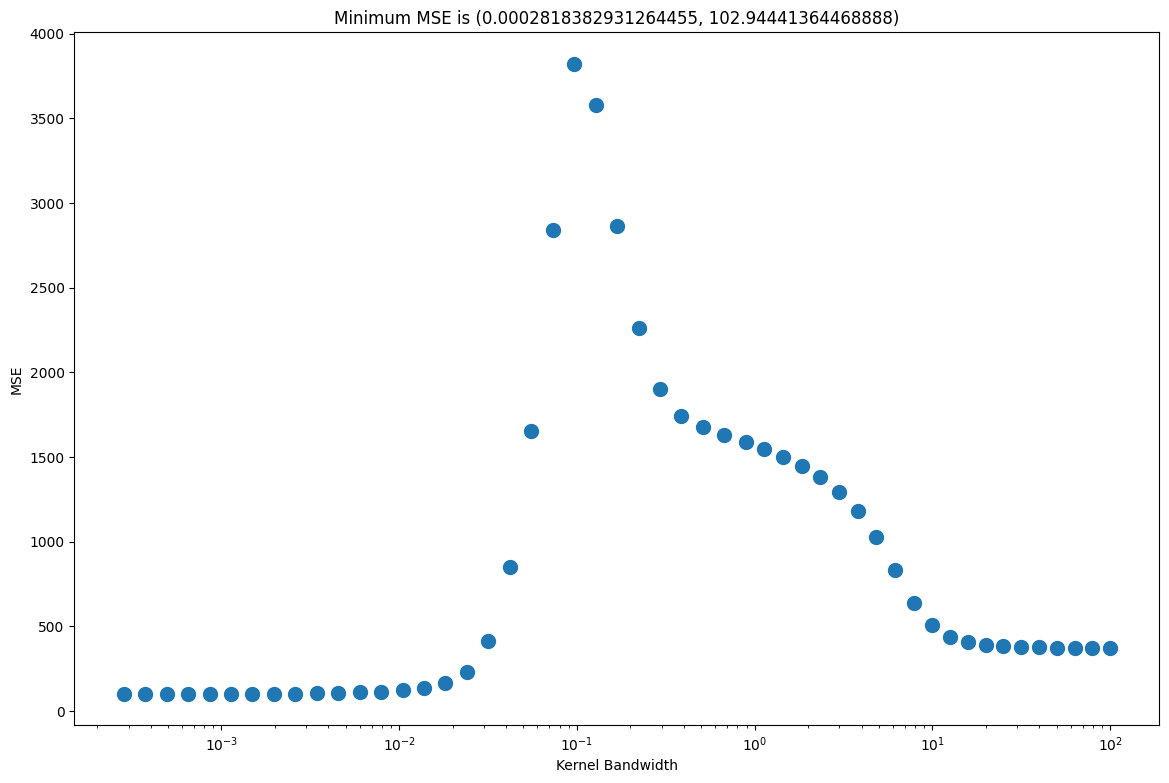

In [5]:
fig, ax = plt.subplots(figsize=(14,9))
mses.plot(kind="scatter", x="bw", y="mse", ax=ax, s=100)
ax.set_xscale("log")
ax.set_ylabel("MSE")
ax.set_xlabel("Kernel Bandwidth")
ax.set_title(f"Minimum MSE is {mses.iloc[np.argmin(mses.mse), 0], mses.iloc[np.argmin(mses.mse), 1]}")

In [ ]:
curr_rmse = np.inf
toSave = False
i = 0
for file in zip(*[true_files, local_files, bws]):
    bw = file[-1]
    all_true_states = np.load(file[0])
    all_local_states = np.load(file[1])
    if all_local_states.shape[0] != 2: continue
    if (len(all_true_states.shape) == len(all_local_states.shape) == 4):
        time_steps = np.linspace(config.t0,config.deltaT*all_true_states.shape[2],all_true_states.shape[2])
        all_global_errors = np.sum(np.power(all_true_states- all_local_states,2), axis=-1)
        all_global_errors=all_global_errors.reshape(-1, all_global_errors.shape[-1])            # (K, N, T)
        total_local_errors = np.sqrt(np.mean(all_global_errors, axis=(0)))/np.sqrt(time_steps)
        all_paths_err = np.sqrt(all_global_errors)/np.sqrt(time_steps)
        total_local_errors[total_local_errors==np.inf] = 0.
        all_paths_err[all_paths_err==np.inf] = 0.
        total_local_errors_minq, total_local_errors_maxq  = np.quantile(all_paths_err, q=[0.005, 0.995], axis=0) # (T,)
        print(total_local_errors[-1], bw, curr_rmse)
        i += 1
        if total_local_errors[-1]  < curr_rmse:
            curr_rmse = total_local_errors[-1]
            fig, ax = plt.subplots(figsize=(14,9))
            plt.grid(True)
            ax.scatter(time_steps, total_local_errors)
            plt.fill_between(time_steps,y1=total_local_errors_minq, y2=total_local_errors_maxq, color="blue", alpha=0.4)
            ax.set_title(rf"Pathwise RMSE for Nadaraya Estimator for $\mu_5$",fontsize=40)
            ax.set_ylabel("MSE", fontsize=38)
            ax.set_xlabel("Time Axis", fontsize=38)
            ax.tick_params(labelsize=38)
            plt.tight_layout()
            if toSave:
                plt.savefig((root_dir + f"DiffusionModelPresentationImages/IIDNadaraya/20DLnz/IIDNadaraya_{config.ndims}DLnz_DriftTrack_{round(bw, 6)}bw_{config.forcing_const}FConst_{config.forcing_const}FConst_{round(total_local_errors_minq[-1], 8)}_MinIQR_{round(total_local_errors[-1], 8)}MeanIQR_{round(total_local_errors_maxq[-1], 8)}_MaxIQR").replace(".", "")+".png")
            plt.show()
            plt.close()
            print(f"Final time cumulative MSE local-time error {total_local_errors[-1]} with IQR ({total_local_errors_minq[-1], total_local_errors_maxq[-1]})at bw {bw} for {config.forcing_const}FConst\n")

In [ ]:
from utils.resource_logger import wallclock_and_system_metrics
data = wallclock_and_system_metrics(config.nadaraya_resource_logging_path, inclusive=False)
data